In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Hilbert-Huang Analysis

This tutorial will cover some steps involved in decomposing and analysing non-stationary signals using the Hilbert-Huang Transform (HHT) using `periodicity`. While usually based on the traditional Empirical Mode Decomposition (EMD), the HHT can be applied to any decomposition of the signal in AM-FM modes; for this tutorial, we will illustrate how to combine ideas from recent improvements on the EMD in our custom HHT object.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from periodicity.core import TSeries
from periodicity.data import SunSpots
from periodicity.decomposition import CEEMDAN
from periodicity.timefrequency import HHT

In [3]:
plt.rc("lines", linewidth=1.0, linestyle="-", color="black")
plt.rc("font", family="sans-serif", weight="normal", size=12.0)
plt.rc("text", color="black", usetex=True)
plt.rc("text.latex", preamble="\\usepackage{cmbright}")
plt.rc(
    "axes",
    edgecolor="black",
    facecolor="white",
    linewidth=1.0,
    grid=False,
    titlesize="x-large",
    labelsize="x-large",
    labelweight="normal",
    labelcolor="black",
)
plt.rc("axes.formatter", limits=(-4, 4))
plt.rc(("xtick", "ytick"), labelsize="x-large", direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc(("xtick.major", "ytick.major"), size=7, pad=6, width=1.0)
plt.rc(("xtick.minor", "ytick.minor"), size=4, pad=6, width=1.0, visible=True)
plt.rc("legend", numpoints=1, fontsize="x-large", shadow=False, frameon=False)

## Preprocessing

We will be analysing the Sunspot dataset, included in the `periodicity.data` module. These are daily measurements of the sunspot number from January 1818 up to June 2021, just over 200 years of observations. First we're going to perform some preprocessing, cleaning the bad measurements and resampling at a uniform 10-day cadence using a regularized cubic spline interpolation. This is important since our decomposition algorithm requires uniformly-sampled data.

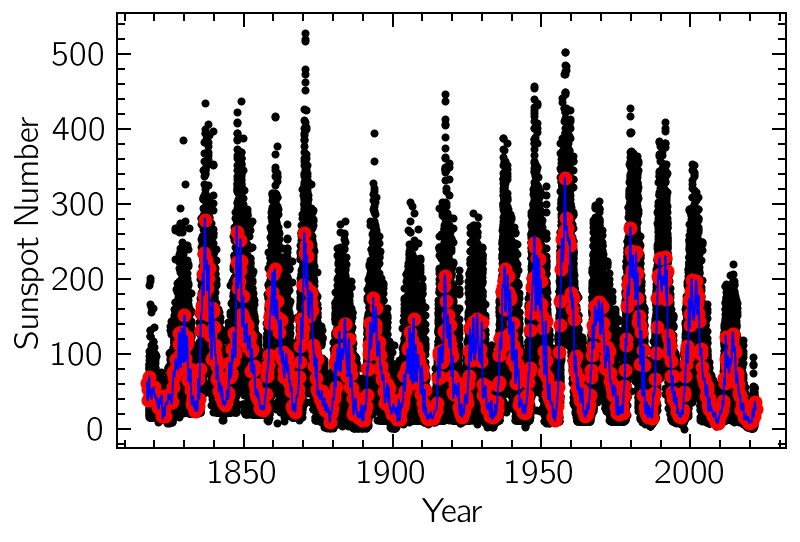

In [4]:
t, y = SunSpots()
# bad measurements are marked with -1
sun = TSeries(t, y)[y > 0]
sun.plot("k.")
# bin to 90-day cadence to attenuate high-frequency noise
# pad in order to avoid edge effects when interpolating
sun = sun.downsample(dt=90/365).pad(2, mode="reflect", reflect_type="odd")
sun.plot("ro")
# resample at 10-day intervals using a noise estimate to regularize the spline interpolation
new_time = np.arange(sun.time[0], sun.time[-1], 10/365)
sun = sun.interp(new_time, method="spline", s=sun.estimate_noise())
sun.plot("b")
plt.xlabel("Year")
plt.ylabel("Sunspot Number");

## Modifying the HHT

To define a HHT object, we can use any custom-made function that accepts a `TSeries` and returns a list of modes. Here we define a Complete Ensemble EMD with Adaptive Noise (see [Colominas et al. 2014](https://www.academia.edu/16712642/Improved_complete_ensemble_EMD_A_suitable_tool_for_biomedical_signal_processing)) using the CEEMDAN object from `periodicity.decomposition` and combine it with the postprocessing algorithm from [Wu and Huang (2009)](http://perso.ens-lyon.fr/pierre.borgnat/MASTER2/EEMD.pdf). This results in more well-behaved modes, with less mixing than with a standard EMD.

In [5]:
def my_emd(signal):
    emd = CEEMDAN(ensemble_size=50, random_seed=42, cores=4)
    emd(signal, progress=True)
    emd.postprocessing()
    return emd.c_modes

frequency = np.arange(0.004, 4.0, 0.001)
hht = HHT(frequency, emd=my_emd, method="NHT", norm_type="lmd", smooth_width=5)

Calling the resulting object on our solar time series performs the given decomposition and also calculates the instantaneous frequencies and amplitudes using a method defined by the `method` keyword (in this case, the Normalized Hilbert Transform).

In [6]:
spectrogram = hht(sun)

White noise: done
Mode #1: done
Mode #2: done
Mode #3: done
Mode #4: done
Mode #5: done
Mode #6: done
Mode #7: done
Mode #8: done
Mode #9: done


The resulting time-frequency representation can be visualized using standard plotting utilities built-in the `TFSeries` object. Notice how the frequency resolution can get arbitrarily small, circumventing the Heisenberg uncertainty principle that limits linear models (like the ones based on wavelets or on Fourier transforms).

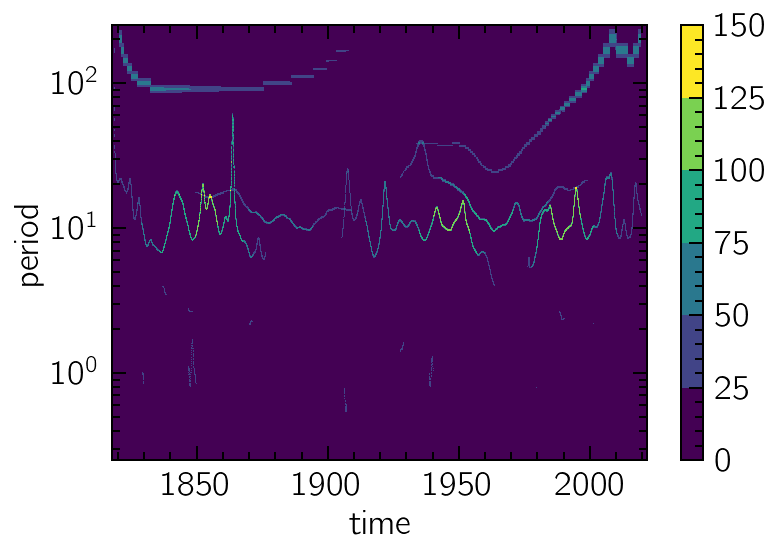

In [7]:
spectrogram.contourf(y="period")
plt.yscale('log');

We can project the result on the time axis and get a decent approximation to the global amplitude variations of the signal: 

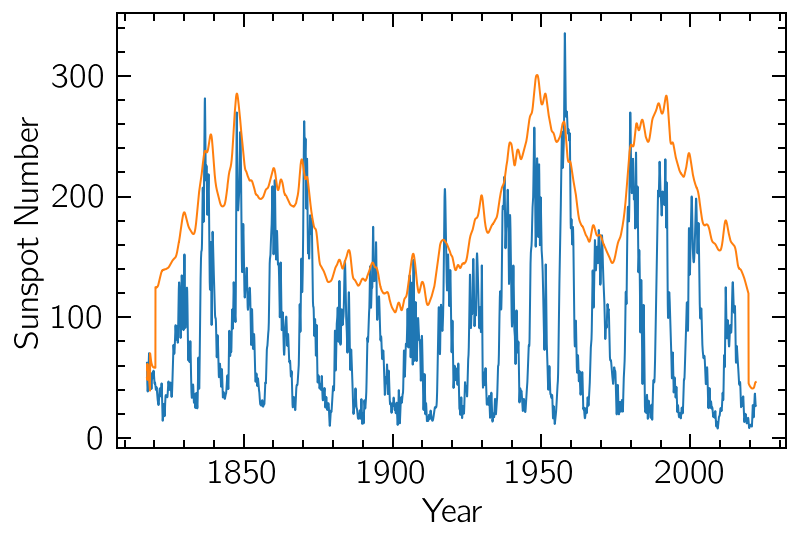

In [8]:
sun.plot()
spectrogram.sum("frequency").plot()
plt.xlabel("Year")
plt.ylabel("Sunspot Number");

## Individual modes and the Hilbert Spectrum

The modes resulting from the decomposition can also be individually accessed, if any further processing is required. Here we'll visualize their relative contributions to the original series:

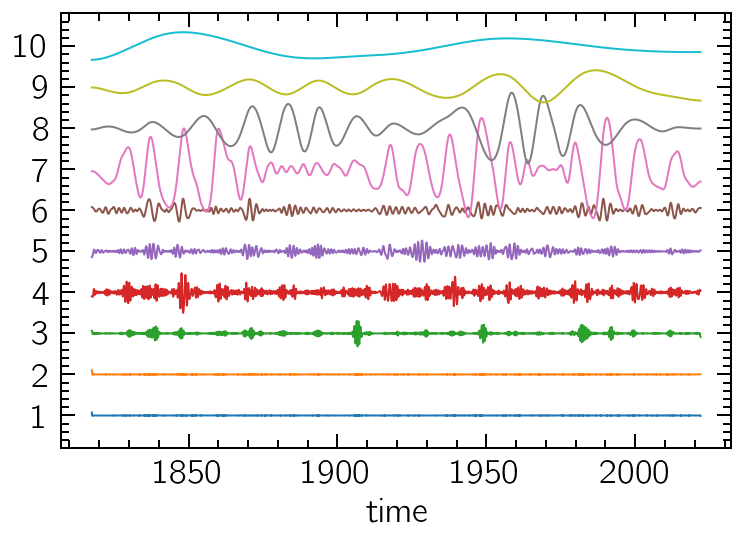

In [9]:
for i in range(len(hht.modes)):
    (100 * i + hht.modes[i]).plot()

plt.yticks(np.arange(0, 1000, 100), np.arange(1, 11))
plt.ylim(-80, 980);

Notice that, as expected, the noisy high-frequency modes are sifted first, and the long-term trends are last. This filter-bank-like behaviour of the decomposition can be better observed by determining each component's frequency distribution (weighed by their corresponding amplitudes) in a sort of Global Hilbert Spectrum.

We'll plot them as a collection of histograms from the `instant_fs` and `instant_as` attributes:

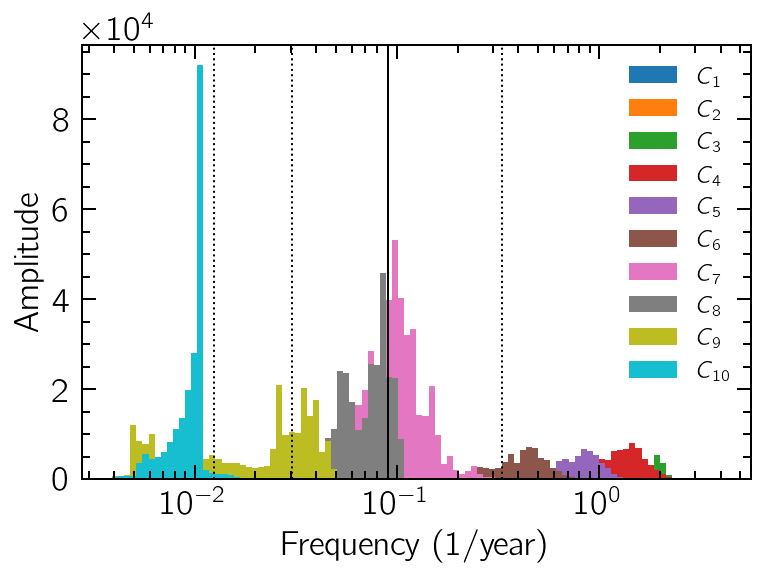

In [10]:
bins = np.logspace(-8, 2, 101, base=2)
for i in range(len(hht.instant_fs)):
    plt.hist(
        hht.instant_fs[i].values,
        weights=hht.instant_as[i].values,
        bins=bins,
        label=f"$C_{{{i+1}}}$",
    )
plt.xscale("log")
plt.axvline(1/3, ls=":")   # The quasi-biennial/quasi-triennial oscillations (C6)
plt.axvline(1/11)          # The Schwabe cycle (C7+C8)
plt.axvline(1/33, ls=":")  # Thrice the Schwabe cycle's period (C9)
plt.axvline(1/80, ls=":")  # The century-long Gleissberg cycle (C10)
plt.xlabel("Frequency (1/year)")
plt.ylabel("Amplitude")
plt.legend(fontsize=12);

In the figure above, the solid vertical line corresponds to a 11-year period, which is the main periodicity from the notorious Schwabe cycle of the magnetic activity of the Sun, and the one we were expecting to find in our data. We also highlight with dotted lines other periodicities known to occur in the Sun, especially the short biennial/triennial cycles (with very low relative contributions) and the ~80-year-long Gleissberg cycle.

We can use a subset of these modes to reconstruct a filtered version of the original signal. For example, we can discard the highest frequencies modes (more likely to be contaminated by noise) and focus on the 7th mode onwards:

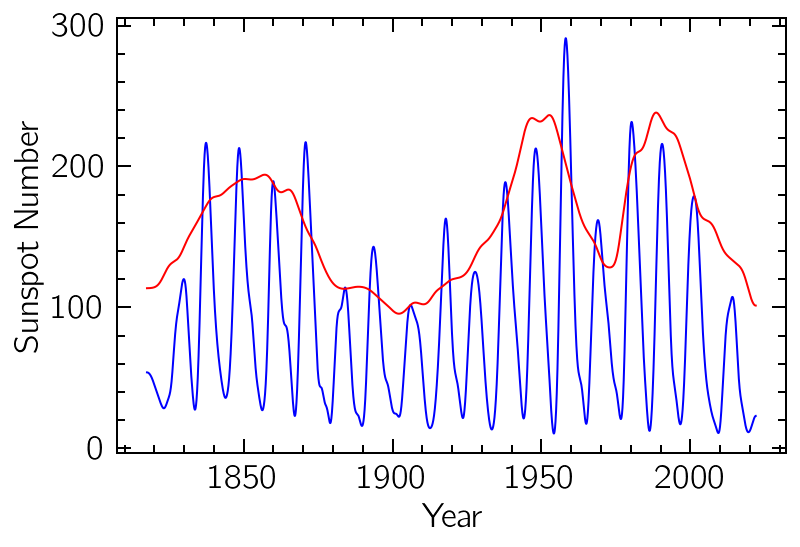

In [11]:
residue = hht.signal - sum(hht.modes)  # monotonic residue corresponding to the global mean/trend
(sum(hht.modes[6:10]) + residue).plot(color="b")  # low-pass filtered version of the original data
sum(hht.instant_as[6:10]).plot(color="r")  # corresponding amplitude variations
plt.xlabel("Year")
plt.ylabel("Sunspot Number");

Notice how the amplitude variations of the data also seem to present a seasonality very similar to the Gleissberg cycle. Periodicity analysis on the amplitude of signals can sometimes be an interesting area of investigation, and the HHT can be used as a way to extract this information.